In [171]:
import gym
from gym import spaces
from gym.utils import seeding
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
import pandas as pd
import numpy as np

In [172]:
from arctic import CHUNK_STORE, Arctic

In [173]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)


2020-10-28 18:13:32,081	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.


In [174]:

def load_data(price_source='Alpaca_Equity_daily',tickers=['SPY','QQQ'],start='2008-01-02',end='2010-01-02'):
    '''Returned price data to use in gym environment'''
    ## Load data 
    ## Each dataframe will have columns date and a collection of fields 
    if price_source in ['Alpaca_Equity_daily', 'Alpaca_Equity_minute', 'Quandl_Futures_daily']:
        price_df = []
        a = Arctic('localhost')
        lib = a[price_source]
        for t in tickers:
            df1 = lib.read(t).set_index('date').loc[start:end]
            price_df.append(df1[['Open','Volume']])
    if price_source in ['csvdata']:
        price_df = []
        for t in tickers:
            df1 = pd.read_csv('csvdata/{}.csv'.format(t)).set_index('date').loc[start:end]
            price_df.append(df1)
    ## Merge data 
    ## Reference dataframe is taken from the first ticker read where the column labels are assumed to be the same
    if len(price_df) > 0:
        ref_df = price_df[0]
        ref_df_columns = price_df[0].columns
        for i in range(1,len(price_df)):
            ref_df = ref_df.merge(price_df[i], how='outer', on='date',)
        merged_df = ref_df.sort_values(by='date').fillna(0)
    ## Prepare price tensor for observation space 
    price_tensor = np.zeros(shape=(merged_df.shape[0],len(ref_df_columns),len(price_df)))
    for count in range(len(price_df)):
        price_tensor[:,:,count] = merged_df.values[:,len(ref_df_columns)*count:len(ref_df_columns)*(count+1)]
    
    return {'dates':merged_df.index, 'fields':ref_df_columns, 'data':price_tensor }


class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data
        price_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        self.dates = price_data['dates']
        self.fields = price_data['fields']
        self.pricedata = price_data['data']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_features = len(self.fields) * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at open, use log return of open price in the following day 
        next_day_log_return = self.pricedata[self.index+1,0,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        price_lookback = self.pricedata[self.index-self.lookback:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        self.observation = np.concatenate( (price_lookback,  metrics,
                                            self.position_series[self.index-self.lookback:self.index]), axis=1)
            
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        
        self.metric = 0                    
        self.index = self.lookback
        # Observation join the price, metric and position 
        price_lookback = self.pricedata[:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series, self.metric_series)).transpose()
        self.observation = np.concatenate((price_lookback, metrics, self.position_series), axis=1)
        
        return self.observation
    
    
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost 


In [175]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [176]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 8000
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 25
config['sgd_minibatch_size'] = 3200
config['model']['fcnet_hiddens'] = [50, 25]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2020-12-31'}


In [177]:
PPO_agent = PPOTrainer(config, Equitydaily)

2020-10-28 18:14:45,588	INFO trainable.py:252 -- Trainable.setup took 71.018 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-10-28 18:14:45,589	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [178]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2020-12-31'})

In [179]:
PPO_agent.restore('checkpoint_49970/checkpoint-49970')

2020-10-28 18:15:48,674	INFO trainable.py:481 -- Restored on 155.198.192.44 from checkpoint: checkpoint_49970/checkpoint-49970
2020-10-28 18:15:48,675	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 49970, '_timesteps_total': None, '_time_total': 609852.200548172, '_episodes_total': 499700}


In [180]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    action = agent.compute_action(state)
    #action = np.array([1,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)


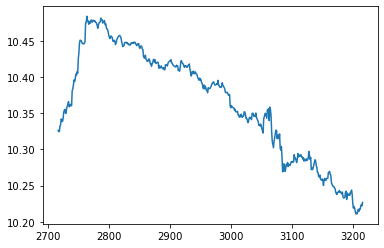

In [188]:

pd.Series(env.log_return_series).cumsum()[-500:].plot()

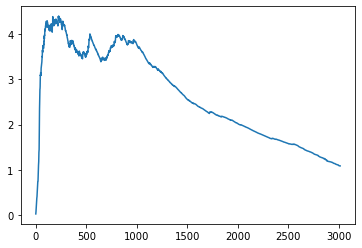

In [182]:
pd.Series(reward_list).cumsum().plot()

In [183]:
position = pd.DataFrame(env.position_series)
position.index = env.dates[:-1]
position.columns = env.tickers + ['Cash']
position

,SPY,QQQ,SHY,GLD,TLT,LQD,Cash
date,,,,,,,
2008-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2020-10-06,-0.174436,-0.136621,-0.125495,0.088971,-0.347071,-0.098113,-0.029293
2020-10-07,0.197686,-0.003326,0.049477,0.197686,0.197686,0.156454,0.197686
2020-10-08,0.236689,-0.088875,-0.188185,0.106049,-0.236689,-0.042319,-0.101193


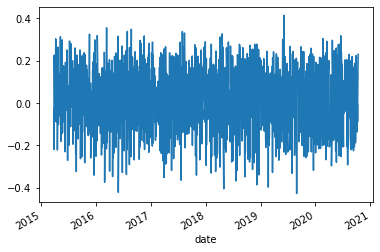

In [184]:
position['QQQ'][-1400:].plot()

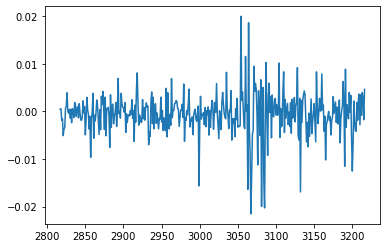

In [185]:
pd.Series(env.log_return_series)[-400:].plot()

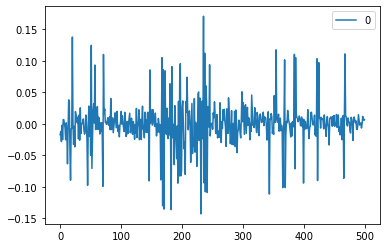

In [169]:
pd.DataFrame(env.pricedata[:,0,1])[:500].plot()

SAC

In [150]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [151]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 2500
config["timesteps_per_iteration"] = 10000
config["buffer_size"] = 20000
config["n_step"] = 10

config['Q_model']['fcnet_hiddens'] = [50, 50]
config['policy_model']['fcnet_hiddens'] = [50, 50]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2018-12-31'}

In [152]:
def load_data(price_source='Alpaca_Equity_daily',tickers=['SPY','QQQ'],start='2008-01-02',end='2010-01-02'):
    '''Returned price data to use in gym environment'''
    ## Load data 
    ## Each dataframe will have columns date and a collection of fields 
    if price_source in ['Alpaca_Equity_daily', 'Alpaca_Equity_minute', 'Quandl_Futures_daily']:
        price_df = []
        a = Arctic('localhost')
        lib = a[price_source]
        for t in tickers:
            df1 = lib.read(t).set_index('date').loc[start:end]
            price_df.append(df1[['Open','Volume']])
    if price_source in ['csvdata']:
        price_df = []
        for t in tickers:
            df1 = pd.read_csv('csvdata/{}.csv'.format(t)).set_index('date').loc[start:end]
            price_df.append(df1)
    ## Merge data 
    ## Reference dataframe is taken from the first ticker read where the column labels are assumed to be the same
    if len(price_df) > 0:
        ref_df = price_df[0]
        ref_df_columns = price_df[0].columns
        for i in range(1,len(price_df)):
            ref_df = ref_df.merge(price_df[i], how='outer', on='date',)
        merged_df = ref_df.sort_values(by='date').fillna(0)
    ## Prepare price tensor for observation space 
    price_tensor = np.zeros(shape=(merged_df.shape[0],len(ref_df_columns),len(price_df)))
    for count in range(len(price_df)):
        price_tensor[:,:,count] = merged_df.values[:,len(ref_df_columns)*count:len(ref_df_columns)*(count+1)]
    
    return {'dates':merged_df.index, 'fields':ref_df_columns, 'data':price_tensor }


class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data
        price_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        self.dates = price_data['dates']
        self.fields = price_data['fields']
        self.pricedata = price_data['data']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_features = len(self.fields) * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at open, use log return of open price in the following day 
        next_day_log_return = self.pricedata[self.index+1,0,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        price_lookback = self.pricedata[self.index-self.lookback:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        self.observation = np.concatenate( (price_lookback,  metrics,
                                            self.position_series[self.index-self.lookback:self.index]), axis=1)
            
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        
        self.metric = 0                    
        self.index = self.lookback
        # Observation join the price, metric and position 
        price_lookback = self.pricedata[:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series, self.metric_series)).transpose()
        self.observation = np.concatenate((price_lookback, metrics, self.position_series), axis=1)
        
        return self.observation
    
    
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost 


In [153]:
SAC_agent = SACTrainer(config, Equitydaily)

2020-10-19 21:57:17,672	WARNING sac_tf_policy.py:36 -- When not using a state-preprocessor with SAC, `fcnet_hiddens` will be set to an empty list! Any hidden layer sizes are defined via `policy_model.fcnet_hiddens` and `Q_model.fcnet_hiddens`.
2020-10-19 21:57:20,103	INFO trainable.py:252 -- Trainable.setup took 76.918 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-10-19 21:57:20,104	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [154]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2020-12-31'})

In [155]:
SAC_agent.restore('checkpoint_3261/checkpoint-3261')

2020-10-19 21:58:32,937	INFO trainable.py:481 -- Restored on 155.198.192.44 from checkpoint: checkpoint_3261/checkpoint-3261
2020-10-19 21:58:32,939	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 3261, '_timesteps_total': None, '_time_total': 19511.168674230576, '_episodes_total': 12700}


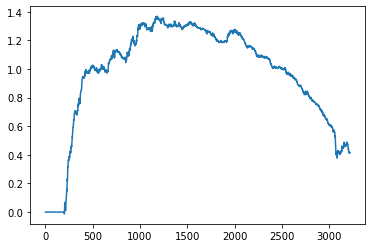

In [156]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    action = SAC_agent.compute_action(state)
    #action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)



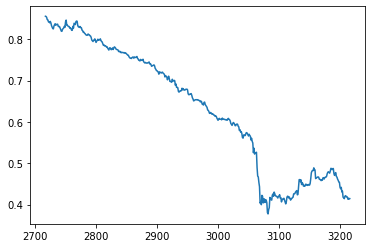

In [161]:
pd.Series(env.log_return_series).cumsum()[-500:].plot()

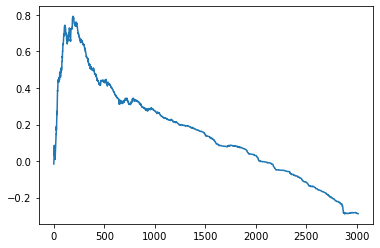

In [157]:
pd.Series(reward_list).cumsum().plot()

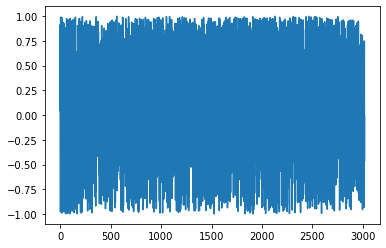

In [158]:
pd.DataFrame(actions)[0].plot()

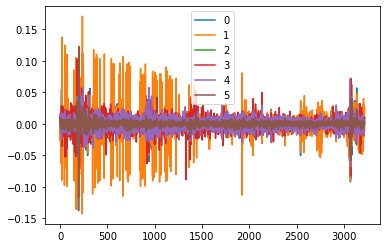

In [159]:
pd.DataFrame(env.pricedata[:,0,:]).plot()

SAC with a reward function of the diff between cumulative returns 

In [4]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 250
config["timesteps_per_iteration"] = 1000
config["buffer_size"] = 20000
config["n_step"] = 10

config['Q_model']['fcnet_hiddens'] = [50, 50]
config['policy_model']['fcnet_hiddens'] = [50, 50]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2018-12-31'}

In [75]:

def load_data(price_source='Alpaca_Equity_daily',tickers=['SPY','QQQ'],start='2008-01-02',end='2010-01-02'):
    '''Returned price data to use in gym environment'''
    ## Load data 
    ## Each dataframe will have columns date and a collection of fields 
    if price_source in ['Alpaca_Equity_daily', 'Alpaca_Equity_minute', 'Quandl_Futures_daily']:
        price_df = []
        a = Arctic('localhost')
        lib = a[price_source]
        for t in tickers:
            df1 = lib.read(t).set_index('date').loc[start:end]
            price_df.append(df1[['Open','Volume']])
    if price_source in ['csvdata']:
        price_df = []
        for t in tickers:
            df1 = pd.read_csv('csvdata/{}.csv'.format(t)).set_index('date').loc[start:end]
            price_df.append(df1)
    ## Merge data 
    ## Reference dataframe is taken from the first ticker read where the column labels are assumed to be the same
    if len(price_df) > 0:
        ref_df = price_df[0]
        ref_df_columns = price_df[0].columns
        for i in range(1,len(price_df)):
            ref_df = ref_df.merge(price_df[i], how='outer', on='date',)
        merged_df = ref_df.sort_values(by='date').fillna(0)
    ## Prepare price tensor for observation space 
    price_tensor = np.zeros(shape=(merged_df.shape[0],len(ref_df_columns),len(price_df)))
    for count in range(len(price_df)):
        price_tensor[:,:,count] = merged_df.values[:,len(ref_df_columns)*count:len(ref_df_columns)*(count+1)]
    
    return {'dates':merged_df.index, 'fields':ref_df_columns, 'data':price_tensor }


class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data
        price_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        self.dates = price_data['dates']
        self.fields = price_data['fields']
        self.pricedata = price_data['data']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_features = len(self.fields) * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at open, use log return of open price in the following day 
        next_day_log_return = self.pricedata[self.index+1,0,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [action], axis=0)
        today_portfolio_return = np.sum(action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        if pd.Series(self.log_return_series).size > 100: 
            recent_series = pd.Series(self.log_return_series)[-100:]
            whole_series = pd.Series(self.log_return_series)
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = 0
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        price_lookback = self.pricedata[self.index-self.lookback:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        self.observation = np.concatenate( (price_lookback,  metrics,
                                            self.position_series[self.index-self.lookback:self.index]), axis=1)
            
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        
        self.metric = 0                    
        self.index = self.lookback
        # Observation join the price, metric and position 
        price_lookback = self.pricedata[:self.index,:,:].reshape(self.lookback,-1)
        metrics = np.vstack((self.log_return_series, self.metric_series)).transpose()
        self.observation = np.concatenate((price_lookback, metrics, self.position_series), axis=1)
        
        return self.observation
    
    
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost 


In [76]:

# Train agent 
agent = SACTrainer(config, Equitydaily)

2020-10-19 13:28:35,902	WARNING sac_tf_policy.py:36 -- When not using a state-preprocessor with SAC, `fcnet_hiddens` will be set to an empty list! Any hidden layer sizes are defined via `policy_model.fcnet_hiddens` and `Q_model.fcnet_hiddens`.
2020-10-19 13:28:38,113	INFO trainable.py:252 -- Trainable.setup took 75.004 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-10-19 13:28:38,115	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [77]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','LQD'], 'lookback':200, 'start':'2008-01-02', 'end':'2020-12-31'})

In [78]:
agent.restore('checkpoint_13272/checkpoint-13272')

2020-10-19 13:29:54,867	INFO trainable.py:481 -- Restored on 155.198.192.44 from checkpoint: checkpoint_13272/checkpoint-13272
2020-10-19 13:29:54,868	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 13272, '_timesteps_total': None, '_time_total': 14658.747411251068, '_episodes_total': 15700}


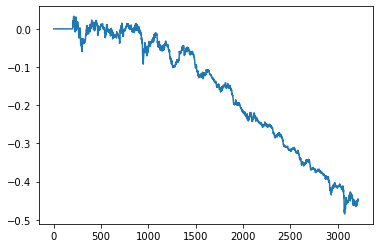

In [79]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    action = agent.compute_action(state)
    #action = np.array([0,0,0,1,0,0,0])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

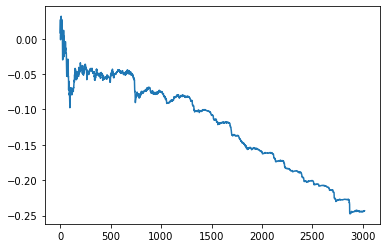

In [80]:
pd.Series(reward_list).cumsum().plot()

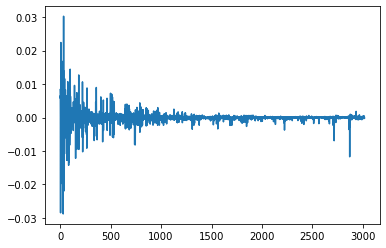

In [81]:
pd.Series(reward_list).plot()

In [61]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return

In [66]:
max_drawdown(pd.Series(env.log_return_series))

-0.4394242243444886

In [67]:
annual_return(pd.Series(env.log_return_series))

-0.03626487255199695